In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_formatting import *
from collections import Counter
import numpy as np
import time

import pandas as pd
import geopandas as gpd
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rc('axes', axisbelow=True)
%matplotlib inline

In [2]:
first_date = '2020-07-27'
last_date = '2020-12-16'

weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

alldates = pd.date_range(start='2020-01-06', end='2020-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
DATE_DF = DATE_DF.loc[(DATE_DF['date']<=last_date)&(DATE_DF['date']>=first_date)].copy()
DATERANGE = DATE_DF['date'].tolist()

date_dict = {DATERANGE[i]:i for i in range(len(DATERANGE))}

In [3]:
# use creds to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

creds = ServiceAccountCredentials.from_json_keyfile_name('../../universities/data/client_secret.json', scope)
client = gspread.authorize(creds)

referen_sheet = client.open("00_Reference")
summary_sheet = client.open("00_Summary")
summary_data_sheet = summary_sheet.worksheet('summary')

In [4]:
ref_data = pd.DataFrame(referen_sheet.worksheet('reference').get_all_records()).iloc[:,:-1]
massachusetts_df = ref_data.loc[ref_data['state']=='Massachusetts'].copy()
massachusetts_df['ipeds_id'] = massachusetts_df['ipeds_id'].astype(str)
print('n =',massachusetts_df['ipeds_id'].nunique(),'colleges')

n = 91 colleges


In [5]:
ipeds_df = pd.read_csv('../data/ipeds_data.csv', encoding='latin8', dtype={'ipeds_id':str,
                                                                           'Fips County code (HD2019)':str})

rename_ipeds = {'Institution Name':'name', 'Latitude location of institution (HD2019)':'lat',
                'Longitude location of institution (HD2019)':'lon', 'Level of Institution':'institution_level',
                'Control of institution':'institution_control', 'Institution Size':'institution_size_bin',
                'Total enrollment (DRVEF2018)':'enrollment_total','Fips County code (HD2019)':'fips',
                'Full-time enrollment (DRVEF2018)':'enrollment_fulltime', 
                'Endowment per FTE':'endowment_per_fte','State abbreviation (HD2019)':'state',
                'Percent admitted - total (DRVADM2019)':'percent_admitted'}

ipeds_df = ipeds_df.rename(columns=rename_ipeds)
ipeds_df = ipeds_df[['ipeds_id','fips', 'state', 'lat', 'lon', 'institution_level', 'institution_control',
                     'institution_size_bin', 'enrollment_total', 'enrollment_fulltime',
                     'endowment_per_fte', 'percent_admitted']]
ipeds_df['fips'] = ("0"+ipeds_df['fips'].str[:]).str[-5:]

min_enroll = 0
enr = 'enrollment_total'
ipeds_df = ipeds_df.loc[(~ipeds_df[enr].isna())&(ipeds_df['state']=='MA')].copy()
ipeds_df = ipeds_df.loc[ipeds_df[enr]>min_enroll].copy()
ipeds_df = ipeds_df.sort_values(enr,ascending=False).reset_index().iloc[:,1:]
college_names = ipeds_df['ipeds_id'].to_list()
print('n =',len(college_names),'colleges (many of these "missing" ones are N/A schools)')

n = 158 colleges (many of these "missing" ones are N/A schools)


In [6]:
all_data = massachusetts_df.loc[massachusetts_df['status'].isin(['completed','cumulative only'])].copy()
to_add = all_data.copy()
print('n =',to_add['ipeds_id'].nunique(),'colleges with time series or cumulative data')

n = 59 colleges with time series or cumulative data


# Pull data from Google Sheets repository

In [7]:
add_dfs = []
nope_ipeds = []
for st in all_data['state'].unique():
    state_sheet = client.open(st)
    ipdfs = to_add.loc[to_add['state']==st]['ipeds_id'].unique()
    print(st,"-",len(ipdfs),"schools left",time.strftime("%H:%M:%S", time.localtime()))
    for ip in ipdfs:
        try:
            print("\t",to_add.loc[to_add['ipeds_id']==ip].college.values[0],
                  time.strftime("%H:%M:%S", time.localtime()))
            add_dfs.append(pd.DataFrame(state_sheet.worksheet(str(ip)).get_all_records()))
            time.sleep(15)
        except:
            print('\t\tcould not do',ip)
            nope_ipeds.append(ip)

    time.sleep(30)

add_df = pd.concat(add_dfs).reset_index().iloc[:,1:]
add_df

Massachusetts - 59 schools left 12:02:15
	 College of Our Lady of the Elms 12:02:15
	 Amherst College 12:02:31
	 Anna Maria College 12:02:47
	 Assumption College 12:03:02
	 Babson College 12:03:18
	 Bard College at Simon's Rock 12:03:57
	 Bay Path University 12:04:13
	 Bentley University 12:04:28
	 Boston College 12:04:44
	 Boston University 12:04:59
	 Brandeis University 12:05:14
	 Bridgewater State University 12:05:30
	 Clark University 12:05:45
	 College of the Holy Cross 12:06:01
	 Curry College 12:06:17
	 Eastern Nazarene College 12:06:32
	 Emerson College 12:06:48
	 Endicott College 12:07:03
	 Fitchburg State University 12:07:19
	 Framingham State University 12:07:35
	 Franklin W Olin College of Engineering 12:07:50
	 Hampshire College 12:08:06
	 Harvard University 12:08:21
	 Lasell University 12:08:37
	 Massachusetts College of Art and Design 12:08:52
	 Massachusetts College of Liberal Arts 12:09:08
	 Massachusetts Institute of Technology 12:09:23
	 Massachusetts Maritime Academ

,date,total_tests,positive_tests,college,url,ipeds_id,notes,when_finished
0,2020-08-01,,,College of Our Lady of the Elms,https://www.elms.edu/student-life/health-cente...,167394,cumulative_tests = 4324,71715202
1,2020-08-02,,,College of Our Lady of the Elms,https://www.elms.edu/student-life/health-cente...,167394,cumulative_cases = 7,71715202
2,2020-08-03,,,College of Our Lady of the Elms,https://www.elms.edu/student-life/health-cente...,167394,,71715202
3,2020-08-04,,,College of Our Lady of the Elms,https://www.elms.edu/student-life/health-cente...,167394,,71715202
4,2020-08-05,,,College of Our Lady of the Elms,https://www.elms.edu/student-life/health-cente...,167394,,71715202
...,...,...,...,...,...,...,...,...
8137,2020-12-12,,,Emmanuel College,https://www.emmanuel.edu/forward.html,165671,,1107634464
8138,2020-12-13,,,Emmanuel College,https://www.emmanuel.edu/forward.html,165671,,1107634464
8139,2020-12-14,,,Emmanuel College,https://www.emmanuel.edu/forward.html,165671,,1107634464
8140,2020-12-15,,,Emmanuel College,https://www.emmanuel.edu/forward.html,165671,,1107634464


## Tidy up the data (strings to integers, etc.)

In [8]:
curr_df = add_df.copy()
curr_df.loc[curr_df['positive_tests']==' ','positive_tests'] = np.nan
curr_df['ipeds_id'] = curr_df['ipeds_id'].astype(str)
curr_df = curr_df.loc[curr_df['date']<=last_date]

curr_df['total_tests'] = curr_df['total_tests'].astype(str)
curr_df['positive_tests'] = curr_df['positive_tests'].astype(str)

curr_df['total_tests'] = curr_df['total_tests'].str.replace(',','')
curr_df['positive_tests'] = curr_df['positive_tests'].str.replace(',','')

curr_df.loc[curr_df['total_tests']=='','total_tests'] = np.nan
curr_df.loc[curr_df['positive_tests']=='','positive_tests'] = np.nan

curr_df['total_tests'] = curr_df['total_tests'].astype(float)
curr_df['positive_tests'] = curr_df['positive_tests'].astype(float)
curr_df['total_tests'] = np.nan_to_num(curr_df['total_tests'])
curr_df['positive_tests'] = np.nan_to_num(curr_df['positive_tests'])

curr_df = curr_df[['date', 'total_tests', 'positive_tests', 'college', 'url', 'ipeds_id', 'notes']]
curr_df = curr_df.merge(DATE_DF,how='left',on='date')

print(curr_df['college'].nunique())
print(curr_df.shape)

59
(8142, 9)


## Merge data with metadata about individual schools, etc.

In [9]:
ma_df = curr_df.copy()

ma_metadata = pd.read_csv('../data/massachusetts-ipeds-metadata.csv',dtype={'ipeds_id':str,'fips':str})
ma_df = ma_df.merge(ma_metadata, how='left', on=['college','ipeds_id'])

cumul_df = ma_df.groupby('ipeds_id').agg({'positive_tests':'sum','total_tests':'sum'}).reset_index()
cumul_df = cumul_df.rename(columns={'positive_tests':'cumulative_cases','total_tests':'cumulative_tests'})
ma_df = ma_df.merge(cumul_df, how='left', on='ipeds_id')

ma_df.loc[ma_df['ipeds_id']=='167394','cumulative_tests'] = 4324
ma_df.loc[ma_df['ipeds_id']=='167394','cumulative_cases'] = 7
ma_df.loc[ma_df['ipeds_id']=='165671','cumulative_tests'] = 1203
ma_df.loc[ma_df['ipeds_id']=='165671','cumulative_cases'] = 6

ma_df['total_tests_per_1000_enrollment']      = ma_df['total_tests'] / ma_df['enrollment_fulltime'] * 1000
ma_df['positive_tests_per_1000_enrollment']   = ma_df['positive_tests'] / ma_df['enrollment_fulltime'] * 1000
ma_df['cumulative_cases_per_1000_enrollment'] = ma_df['cumulative_cases'] / ma_df['enrollment_fulltime'] * 1000
ma_df['cumulative_tests_per_1000_enrollment'] = ma_df['cumulative_tests'] / ma_df['enrollment_fulltime'] * 1000

ma_df['total_tests'] = ma_df['total_tests'].astype(int)
ma_df['positive_tests'] = ma_df['positive_tests'].astype(int)
ma_df['enrollment_total'] = ma_df['enrollment_total'].astype(int)
ma_df['enrollment_fulltime'] = ma_df['enrollment_fulltime'].astype(int)

ma_df = ma_df.sort_values(['college','date'])

ma_df = ma_df[['date','week','college','ipeds_id','total_tests','positive_tests',
               'cumulative_cases','cumulative_tests',
               'total_tests_per_1000_enrollment','positive_tests_per_1000_enrollment',
               'cumulative_cases_per_1000_enrollment','cumulative_tests_per_1000_enrollment',
               'enrollment_total','enrollment_fulltime','institution_size_bin',
               'endowment_per_fte','percent_admitted', 
               'testing_approach','status','urban_rural_designation',        
               'fips','city','state']].reset_index().iloc[:,1:]

# Pull local county-level data from NYT

In [10]:
nyt_data_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
ll = pd.read_csv(nyt_data_url, delimiter=',', dtype={'fips':str})
ll = ll.loc[ll['state']=='Massachusetts'].copy()
ll = ll.loc[~ll['fips'].isna()].copy()
ll = ll.sort_values(['date','fips'])
ll['cases_county'] = ll['cases'].astype(int)
ll['deaths_county'] = ll['deaths'].astype(int)

mass_pops = pd.DataFrame({'fips':sorted(ll['fips'].unique()),
                          'county_population':[212990,124944,565217,17332,789034,70180,466372,
                                               160830,1611699,11399,706775,521202,803907,830662]})

ll = ll.merge(mass_pops, how='left', on='fips')
ll = ll[['date', 'county', 'fips', 'county_population', 'cases_county', 'deaths_county']]

state_df = []
for st in ll.fips.unique():
    ll_st = ll.loc[ll['fips']==st].copy()
    total_deaths_st = ll_st['deaths_county'].values[-1]
    total_cases_st = ll_st['cases_county'].values[-1]

    ll_st['new_cases_county'] = list(np.nan_to_num(ll_st['cases_county'].diff().tolist()).astype(int))
    ll_st['new_deaths_county'] = list(np.nan_to_num(ll_st['deaths_county'].diff().tolist()).astype(int))
    ll_st.loc[ll_st['new_cases_county']<0,'new_cases_county'] = 0
    ll_st.loc[ll_st['new_deaths_county']<0,'new_deaths_county'] = 0
    state_df.append(ll_st)

ll = pd.concat(state_df).sort_values(['date','fips']).reset_index().iloc[:,1:]

ll['new_cases_per_1000_county'] = (ll['new_cases_county'] / ll['county_population'] * 1000)
ll['new_deaths_per_1000_county'] = (ll['new_deaths_county'] / ll['county_population'] * 1000)
ll['cases_per_1000_county'] = (ll['cases_county'] / ll['county_population'] * 1000)
ll['deaths_per_1000_county'] = (ll['deaths_county'] / ll['county_population'] * 1000)

# ll.tail()

ma_df = ma_df.merge(ll, how='left', on=['fips','date'])

In [11]:
# Merge into the main dataset, and save data.
ma_df.to_csv('../data/massachusetts-campus-covid-data-Fall2020.csv',index=False)

# Simple question: are there more cases at in-person IHEs in Massachusetts?

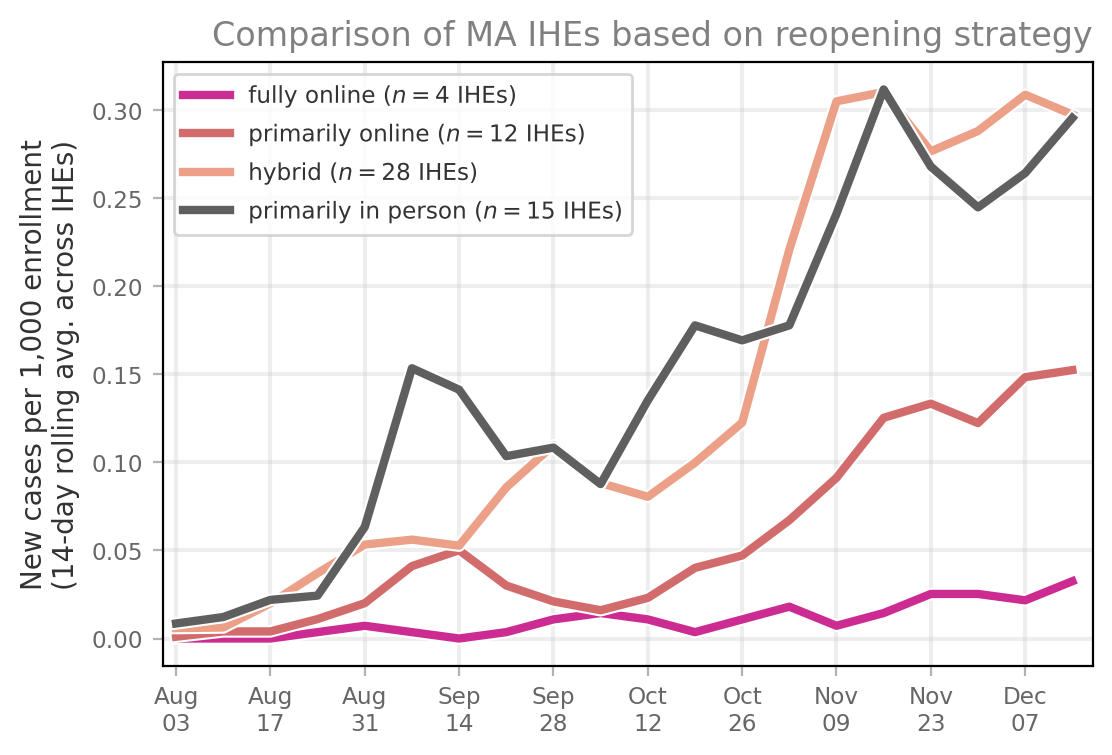

In [12]:
ma_dfs = ma_df.copy()

fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=200)
wid = 28
wid = 2
cols = ['.3','darksalmon','indianred','mediumvioletred'][::-1]

for si, st in enumerate(['primarily in person', 'hybrid', 'primarily online', 'fully online'][::-1]):
    dci = ma_dfs.loc[ma_dfs['status']==st].copy()
    dci_stats = dci.groupby('week').agg({'positive_tests':['mean','count','std']}).reset_index()
    dci_enrol = dci.groupby('week').agg({'enrollment_total':'mean'}).reset_index()
    dci_stats = dci_stats['positive_tests'].rename(columns={'mean':'positive_tests_mean',
                                                            'count':'positive_tests_count',
                                                            'std':'positive_tests_std'})
    ci95_hi = []; ci95_lo = []
    for i in dci_stats.index:
        m, c, s = dci_stats.iloc[i]
        ci95_hi.append(m + 1.282*s/np.sqrt(c)) # 80% CIs
        ci95_lo.append(m - 1.282*s/np.sqrt(c)) # 80% CIs
    #     ci95_hi.append(m + 1.96*s/np.sqrt(c)) # 95% CIs
    #     ci95_lo.append(m - 1.96*s/np.sqrt(c)) # 95% CIs

    dci_stats['week'] = dci_enrol['week']
    dci_stats['enrollment_total'] = dci_enrol['enrollment_total']

    dci_stats['positive_tests_ci95_hi'] = ci95_hi; dci_stats['positive_tests_ci95_lo'] = ci95_lo
    dci_stats = dci_stats.merge(DATE_DF.loc[DATE_DF['day']=='Monday'][['date','week']], how='left', on='week')
    
    dci_mean = dci_stats['positive_tests_mean'] / dci_stats['enrollment_total'] * 1000
    dci_upps = dci_stats['positive_tests_ci95_hi'] / dci_stats['enrollment_total'] * 1000
    dci_lows = dci_stats['positive_tests_ci95_lo'] / dci_stats['enrollment_total'] * 1000
    dci_lows[dci_lows<0] = 0
    
    dci_xvals = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in dci_stats['date'].values]
    ax.plot(dci_xvals, dci_mean.rolling(window=wid).mean().values,
            color=cols[si], lw=3, label=st+' ($n=%i$ IHEs)'%dci['ipeds_id'].nunique(),alpha=0.9,
            path_effects=[path_effects.Stroke(linewidth=4.5, foreground='w'), path_effects.Normal()])
#     ax.fill_between(dci_xvals, dci_lows.rolling(window=wid).mean().values,
#                     dci_upps.rolling(window=wid).mean().values, color=cols[si],lw=0,alpha=0.125)
#     ax.fill_between(dci_xvals, dci_lows.rolling(window=wid).mean().values,
#                     dci_upps.rolling(window=wid).mean().values, fc='none',ec=cols[si],lw=1,alpha=0.25)

ax.set_xticks(dci_xvals[1::2])
ax.set_xticklabels(["{:%b\n%d}".format(i) for i in dci_xvals[1::2]])
ax.grid(linewidth=1.5,color='.75',alpha=0.25)
ax.tick_params(labelcolor='.4',color='.7',labelsize='small')
ax.set_xlim(dt.datetime.strptime('2020-08-01',"%Y-%m-%d").date(),
            dt.datetime.strptime('2020-12-17',"%Y-%m-%d").date())
ax.set_ylabel('New cases per 1,000 enrollment\n(14-day rolling avg. across IHEs)', color='.2')
ax.set_title('Comparison of MA IHEs based on reopening strategy', color='.5',x=1,ha='right',fontsize='large')

l = ax.legend(loc=2,ncol=1,fontsize='small')
for text in l.get_texts():
    text.set_color('.2')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])


plt.savefig('../figs/pngs/IHE_MA_fall2020_status.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/IHE_MA_fall2020_status.pdf',bbox_inches='tight')
# plt.savefig('../figs/pngs/IHE_MA_fall2020_status_error.png',dpi=425,bbox_inches='tight')
# plt.savefig('../figs/pdfs/IHE_MA_fall2020_status_error.pdf',bbox_inches='tight')

plt.show()

__________________________

# Use Massachusetts town-by-town data to look at a more local level
Can we understand a case study of -- even within regions with relatively consistent policies in place, is there an added effect of testing?

In [13]:
towns = pd.read_csv('../data/Massachusetts City Data - towns.csv')
towns.loc[towns['new_cases_town']<0,'new_cases_town'] = 0

In [14]:
ddf = DATE_DF.loc[DATE_DF['date']>'2020-07-30'].copy()
ddf['week'] = np.array([[29+i]*7 for i in range(21)]).flatten()[:ddf.shape[0]]

In [15]:
ma_df_town = ma_df.groupby(['date','city']).agg({'positive_tests':'sum',
                                                 'total_tests':'sum','enrollment_fulltime':'sum',
                                                 'ipeds_id':'count'}).reset_index()
ma_df_town = ma_df_town.merge(DATE_DF[['date','day','week']],how='left',on='date')

ma_df_town_g = ma_df_town.groupby(['week','city']).agg({'positive_tests':'sum',
                                         'total_tests':'sum','enrollment_fulltime':'mean',
                                         'ipeds_id':'mean'}).reset_index()

In [16]:
summa = pd.DataFrame({'city':ma_df_town_g['city'].unique(),
                      'total_tests':ma_df_town_g.groupby('city')['total_tests'].sum().values})
summa['enrollment_fulltime'] = ma_df_town_g.groupby('city')['enrollment_fulltime'].mean().values

In [17]:
summa['total_tests_per_1000'] = (summa['total_tests'] / summa['enrollment_fulltime'])*1000
summa['quartiles'] = pd.qcut(summa['total_tests_per_1000'], q=4)
quartile_labs = ['3 to 9 tests','10 to 16 tests','fewer than 3 tests','more than 16 tests']
qmap = dict(zip(list(summa['quartiles'].unique()), quartile_labs))
summa['quartile_label'] = [qmap[q] for q in summa['quartiles']]

In [18]:
df_towns = towns.merge(summa[['city','quartile_label']], how='left', on='city').dropna()

In [19]:
df_town_w = df_towns.groupby(['date','quartile_label']).agg({'new_cases_town':'sum',
                                                             'city':'count',
                                                             'population':'sum'}).reset_index()
df_town_w = df_town_w.loc[df_town_w['date']>'2020-06-18'].copy()

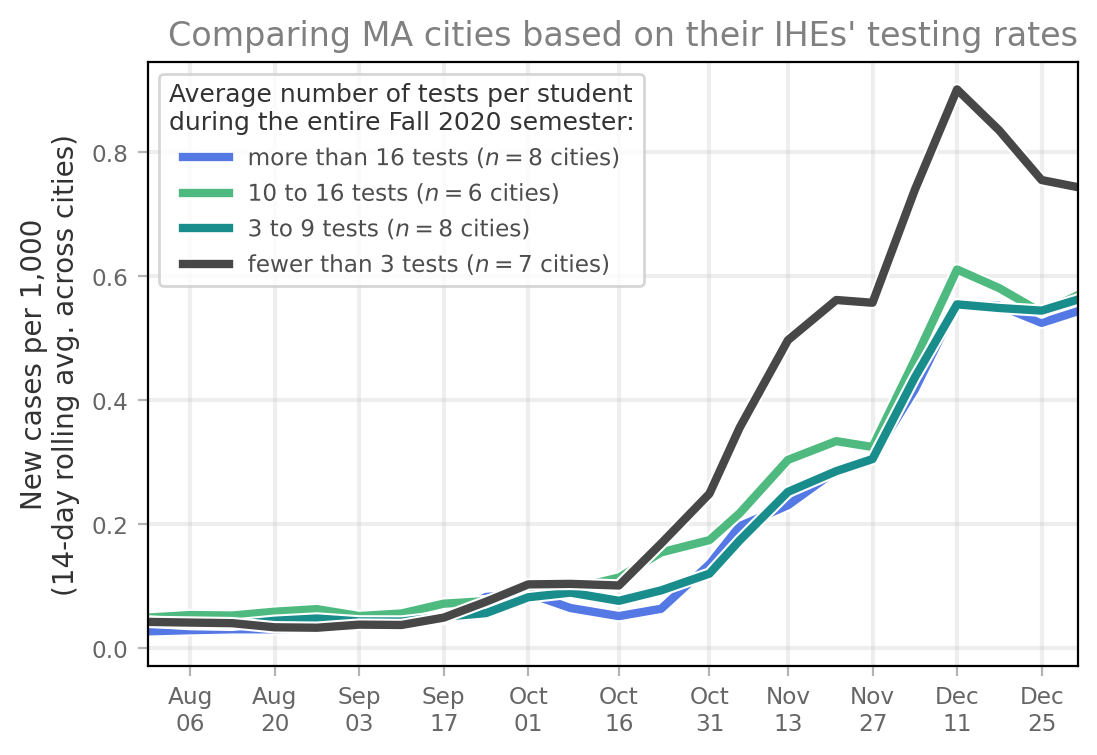

In [20]:
fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=200)

wid = 2
cols = plt.cm.viridis(np.linspace(0.1,0.9,4))
cols = ['.2','teal','mediumseagreen','royalblue'][::-1]
for qi,q in enumerate(['fewer than 3 tests','3 to 9 tests','10 to 16 tests','more than 16 tests'][::-1]):
    dfi = df_town_w.loc[df_town_w['quartile_label']==q].copy()
    yvs = (dfi['new_cases_town'] / dfi['population'])*1000/7
    dfi_xvals = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in dfi['date'].values][:-1]
    ax.plot(dfi_xvals, yvs.rolling(window=wid).mean().values[:-1], color=cols[qi],lw=3,
            label=str(q)+" "+'($n=%i$ cities)'%np.mean(dfi['city']),alpha=0.9,
            path_effects=[path_effects.Stroke(linewidth=4.5, foreground='w'), path_effects.Normal()])

ax.set_xticks(dfi_xvals[4::2])
ax.set_xticklabels(["{:%b\n%d}".format(i) for i in dfi_xvals[4::2]])
l = ax.legend(fontsize='small', ncol=1)
l.set_title('Average number of tests per student\nduring the entire Fall 2020 semester:', prop={'size': 9})
for text in l.get_texts():
    text.set_color(".3")
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])

ax.grid(linewidth=1.5, color='.75', alpha=0.25)
ax.tick_params(labelcolor='.4',color='.7',labelsize='small')
ax.set_ylabel('New cases per 1,000\n(14-day rolling avg. across cities)',color='.2')
ax.set_title("Comparing MA cities based on their IHEs' testing rates",x=1,ha='right',color='.5')
ax.get_legend().get_title().set_color(".2")
ax.set_xlim(dt.datetime.strptime('2020-07-30',"%Y-%m-%d").date(),
            dt.datetime.strptime('2020-12-31',"%Y-%m-%d").date())

plt.savefig('../figs/pngs/ma_cities_IHE_testing.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/ma_cities_IHE_testing.pdf',bbox_inches='tight')
plt.show()

## There is surely so much more that needs to be done with this analsis, but it is a start